In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpltools import color
import numpy as np
from scipy import optimize
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import MIstack as MIs
from DSH import SALS as LS

# Small Angle Light Scattering (SALS)

```SALS``` class is designed to analyze far-field light scattering experiments in the small-angle configuration, where image pixels map not in different locations of the sample (as in DSH) but in differetn scattering vectors. A typical speckle field in SALS experiment looks like this:

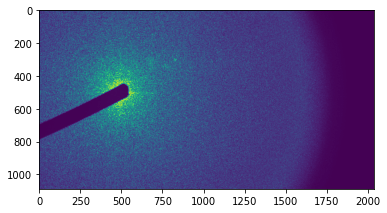

In [2]:
im_shape = (1088, 2040)
plt.imshow(MI.ReadBinary(r'D:\steaime\Data\SALS\210128_Test\sample_image.raw', im_shape, 'B'))

## 1. Configuration

To initialize a ```SALS``` object:

```python
SALS_analyzer = LS.SALS(MIinput, outFolder, ROIs=None, maskRaw=None, BkgCorr=None, expTimes=[1], imgTimes=None, timeAvg_T=None)
```

where:

- ```MIinput``` contains the input images, and can be either a ```MIfile``` or a ```MIstack```
- ```outFolder``` is the output folder path
- ```ROIs``` defines the regions of interest (ROIs) of the analysis (see below)
- ```BkgCorr=[DarkBkg, OptBkg, PDdata]``` contains data for background correction (see below)
- ```expTimes``` is the list of exposure times. With multiple exposure times, ```SALS``` assumes that images in ```MIinput``` cycle through exposure times
- ```imgTimes``` is the list of image times, if images were not acquired at constant FPS (see below)
- ```timeAvg_T``` defines the time averaging window for correlation functions (see below)

### 1.1 ROI definition
The speckle intensity here is not homogeneous as in DSH, but increases moving towards a point, which is the location where the transmitted beam would hit the detector, if there wasn't the black shadow of the beam stop blocking it. The fist step of a SALS analysis, essential to map pixel location in scattering vector (```centerPos```), is to identify the transmitted beam location, and to create a binary mask (```maskRaw```) to exclude from the analysis the pixels shadowed by the beam stop.
By design, ```SALS``` expects that ```centerPos``` is a couple of floats ```(posX, posY)``` specifying the location of the center in pixels, relative to the upper left corner of the image. The upper left corner location is ```(0, 0)```.

Once ```centerPos``` is specified, the analysis can be specialized on annular regions around the center, thereby averaging on scattering vectors of equal magnitude and different azimuthal orientation. 

Azimuthal annuli can be generated using ```GenerateROIs(ROI_specs, imgShape, centerPos, maskRaw)```, where ```ROI_specs=[rSlices, aSlices]```:

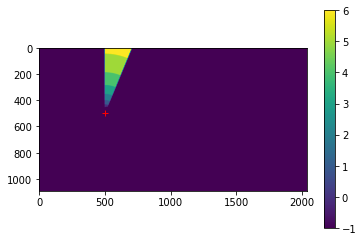

In [36]:
ROI_specs = [np.geomspace(50, 2000, 11), np.linspace(-np.pi/2, -np.pi*3/8, 2)]
px_mask = MI.ReadBinary('..\\SALS_test\\px_mask.raw', im_shape, 'B')
ctrPos = [500, 500]
ROI_map, ROI_coords = LS.GenerateROIs(ROI_specs, im_shape, ctrPos, px_mask)
plt.imshow(ROI_map)
plt.plot(*ctrPos, 'r+')
plt.colorbar()

In [28]:
ROI_specs

[array([  50.        ,   72.30627748,  104.56395526,  151.21260727,
         218.67241479,  316.22776602,  457.30505193,  661.32051955,
         956.35249979, 1383.00578436, 2000.        ]),
 array([-3.14159265,  3.14159265])]

In [26]:
ROI_coords

array([[  61.15313874,    0.        ,   22.30627748,    6.28318531],
       [  88.43511637,    0.        ,   32.25767778,    6.28318531],
       [ 127.88828126,    0.        ,   46.64865201,    6.28318531],
       [ 184.94251103,    0.        ,   67.45980752,    6.28318531],
       [ 267.4500904 ,    0.        ,   97.55535123,    6.28318531],
       [ 386.76640897,    0.        ,  141.07728591,    6.28318531],
       [ 559.31278574,    0.        ,  204.01546762,    6.28318531],
       [ 808.83650967,    0.        ,  295.03198024,    6.28318531],
       [1169.67914208,    0.        ,  426.65328457,    6.28318531],
       [1691.50289218,    0.        ,  616.99421564,    6.28318531]])

### 1.2 Background correction

To extract static structure and form factors from static light scattering (SLS), one needs to measure the background contribution to the scattered intensity, and correct for it. This background contribution can have two sources:

- light scattered by imperfections in the optical apparatus
- intensity detected even with the laser switched off (ambient light, dark counts from the camera)

These contributions can be independently estimated by:

- taking images with the laser switched off (```DarkBkg```)
- taking images with the laser switched on, but with the scattering cell filled with a simple liquid with the same refractive index (```OptBkg```)

```SALS``` can take these measurements together with photodiode measurements (```PDdata```) of both the laser intensity and the transmitted intensity, and use this information to correct for the static background. 

*NOTE (9/2/2021): this functionality is still under development*

### 1.3 Timing

**Exposure times**

Because the dynamic range of a typical 8bit camera is not enough to properly measure typical SLS spectra, where the intensity may vary of several orders of magnitude, the same speckle field is typically recorded using multiple exposure times.
Combining images taken at different exposure time in one unique spectrum requires knowledge of the exposure times (```expTimes```)

**Lag times**

The essence of DLS analysis is comparing the speckle field recorded at two different times. To do that, a list of time delays () must be specified, in image units (```dlsLags```)

**Image times**

In typical SALS experiments, images are acquired at a constant rate (FPS), specified in the metadata of each MIfile (see tutorial 1). However, there are cases in which custom acquisition schemes may be used to enhance the sensitivity to both the fastest and the slowest dynamics. In these cases, the time at which each image has beed taken (```imgTimes```) needs to be provided 

**Averaging period**

SALS analysis uses time resolved correlation (TRC), which provides well-defined correlation values with no need of averaging in time. However, to improve statistics and produce output more directly comparable to traditional DLS, the correlaction values $c_I(t, \tau)$ provided by TRC can be averaged on given time windows to produce intensity correlationc functions $g_2(\tau)-1$. To this end, the averaging window (```timeAvg_T```) needs to be provided, in image units

### 1.4 Initialization

The above parameters can also be specified in a configuration ```*.ini``` file, in which case the ```SALS``` object can be loaded by calling

```python
SALS_analyzer = LS.LoadFromConfig(ConfigFile, input_sect='input')
```

where:

- ```ConfigFile``` is a string with the full path of the config file to read
- ```input_sect``` is a string with the section of the ini file with the relevant parameters (useful to run serial analysis)

In [32]:
SALS_analyzer = LS.LoadFromConfig('DSH\\serial_SALS_config.ini')

## 2. Analysis

SALS analysis can be simply run by calling:

In [33]:
SALS_analyzer.Run(doDLS=True)

MemoryError: Unable to allocate 16.5 GiB for an array with shape (2219520000,) and data type float64

## 3. Postprocess

### 3.1 Loading SLS results

In [5]:
SLSdata, rarr, phiarr, times = LS.OpenSLS(r'D:\steaime\Data\SALS\210202\out_stack_corr', open_raw=False)

In [55]:
def PlotSLS(SLSdata, rs, times=None, timesel=None, OptBkg=None, figsize=(10,8), plot_fmt='.-', cmap=None, legend=True, funcfit=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(SLSdata.shape[1])
    if timesel is None:
        timesel = np.asarray(range(len(times)), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(timesel), cmap=cmap, ax=ax)
    for tidx in timesel:
        if OptBkg is None:
            to_plot = SLSdata[:,tidx]
        else:
            to_plot = SLSdata[:,tidx] - OptBkg
        ax.plot(rs, to_plot, plot_fmt, label='t{0}'.format(times[tidx]))
    if funcfit is not None:
        for tidx in timesel:
            if OptBkg is None:
                to_fit = SLSdata[:,tidx]
            else:
                to_fit = SLSdata[:,tidx] - OptBkg
            popt, _ = optimize.curve_fit(funcfit, rs, to_fit)
            ax.plot(rs, funcfit(rs, *popt), '--', label='t{0}_fit'.format(times[tidx]))
    ax.set_xlabel('r')
    ax.set_ylabel('I')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if legend:
        ax.legend(ncol=2)
    return fig, ax

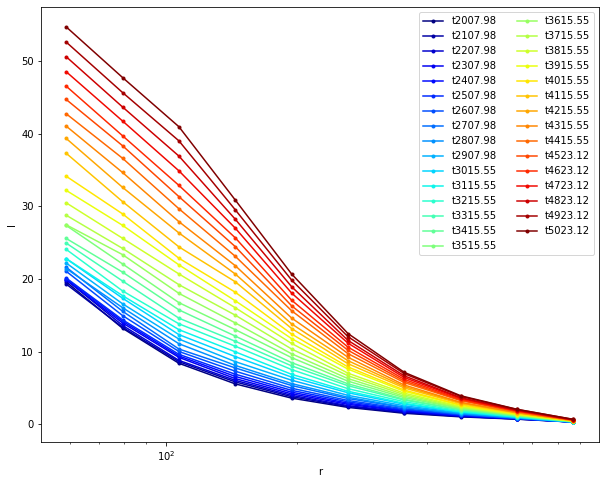

In [69]:
fig, ax = PlotSLS(SLSdata, rarr, times=times, timesel=list(range(400, SLSdata.shape[1]//13, 20)), cmap=mpl.cm.jet)#, OptBkg=SLSdata[:,380]
ax.set_yscale('linear')
#ax.set_ylim([0.1, 40])

### 3.2 Loading DLS results

In [20]:
cIs, times, lags, ROI_list, exptime_list = LS.OpenCIs(r'D:\steaime\Data\SALS\210202\out_stack_corr')#SALS_analyzer.outFolder)
times = times[0]
lags = lags[0]

In [11]:
def PlotContrast(CIlist, times=None, figsize=(10,8), plot_fmt='.-', cmap=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if cmap is not None:
        color.cycle_cmap(len(CIlist), cmap=cmap, ax=ax)
    for i in range(len(CIlist)):
        ax.plot(times, CIlist[i][:,0], plot_fmt, label='ROI{0}'.format(i))
    ax.set_xlabel('t')
    ax.set_ylabel('cI')
    ax.legend(ncol=2)
    return fig, ax

def PlotCIs(CIdata, lags=None, times=None, lag_sel=None, figsize=(10,8), plot_fmt='.-', cmap=None):
    fig, ax = plt.subplots(figsize=figsize)
    if lags is None:
        lags = np.arange(CIdata.shape[1])
    else:
        lags = np.asarray(lags)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if lag_sel is None:
        lag_sel = np.asarray(range(len(lags)), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(lag_sel), cmap=cmap, ax=ax)
    for lidx in lag_sel:
        ax.plot(times, CIdata[:,lidx], plot_fmt, label='d{0}'.format(lags[lidx]))
    ax.set_xlabel('t')
    ax.set_ylabel('cI')
    ax.legend(ncol=2)
    return fig, ax

def PlotCorrFuncs(CorrFuncData, lags, times=None, t_sel=None, figsize=(10,8), plot_fmt='.-', cmap=None, legend=True, 
                  logx=True, logy=False, logG2M1=False, baseline=0, start=1, min_corrval=None, save_file=None):
    fig, ax = plt.subplots(figsize=figsize)
    if times is None:
        times = np.arange(CIdata.shape[0])
    if t_sel is None:
        t_sel = np.asarray(range(CorrFuncData.shape[0]), dtype=int)
    if cmap is not None:
        color.cycle_cmap(len(t_sel), cmap=cmap, ax=ax)
    if save_file is not None:
        save_data = []
        save_hdr=''
    for tidx in t_sel:
        if start=='first':
            start_val = CorrFuncData[tidx][1]
        else:
            start_val=start
        to_plot = (CorrFuncData[tidx]-baseline)/(start_val-baseline)
        if min_corrval is not None:
            to_plot[to_plot<min_corrval] = np.nan
        if logG2M1:
            to_plot = -np.log(to_plot)
        ax.plot(lags[tidx], to_plot, plot_fmt, label='t{0}'.format(times[tidx]))
        if save_file is not None:
            save_data.append(lags[tidx])
            save_data.append(to_plot)
            if save_hdr!='':
                save_hdr += '\t'
            save_hdr += 't' + str(times[tidx])
            if logG2M1:
                save_hdr += '\t-ln(g2-1)(t={0})'.format(times[tidx])
            else:
                save_hdr += '\tg2-1(t={0})'.format(times[tidx])
    ax.set_xlabel(r'$\tau$')
    if logG2M1:
        ax.set_ylabel(r'$-\ln(g_2-1)$')
    else:
        ax.set_ylabel(r'$g_2-1$')
    if logx:
        ax.set_xscale('log')
    if logy:
        ax.set_yscale('log')
    if legend:
        ax.legend(ncol=2)
    if save_file is not None:
        np.savetxt(save_file, np.asarray(save_data).T, delimiter='\t', header=save_hdr)
    return fig, ax

(100, 100000)

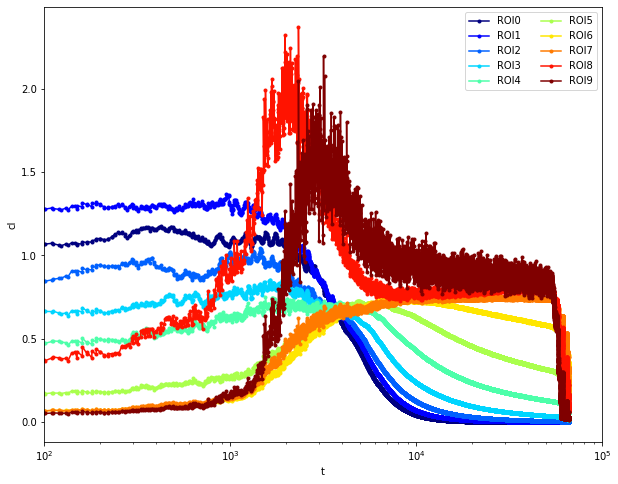

In [26]:
fig, ax = PlotContrast(cIs, times, cmap=mpl.cm.jet)
ax.set_xscale('log')
ax.set_xlim([100, 100000])

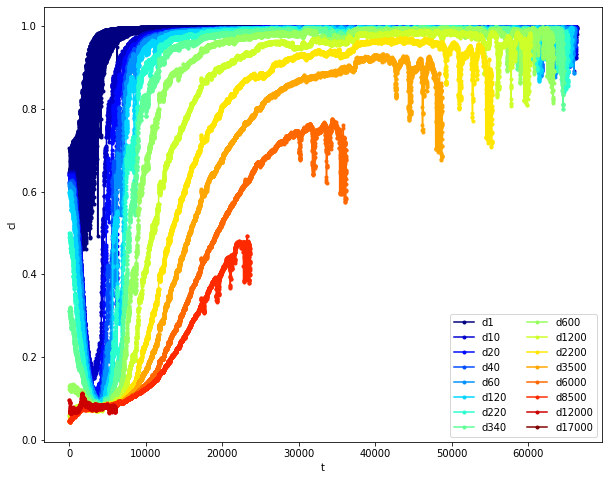

In [58]:
fig, ax = PlotCIs(cIs[7], lags, times, lag_sel=list(range(1, len(lags), 5)), cmap=mpl.cm.jet)

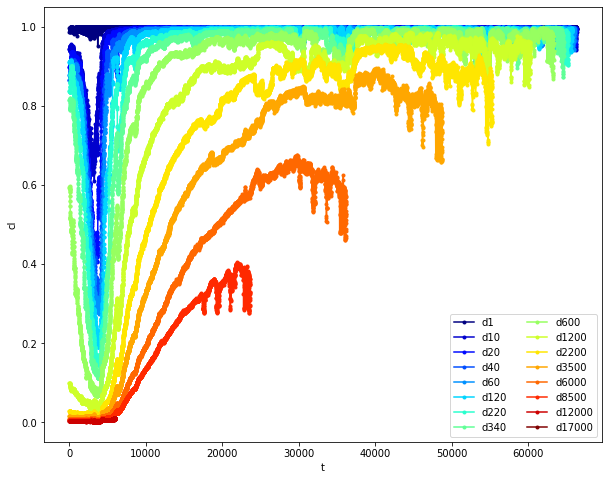

In [36]:
fig, ax = PlotCIs(cIs[2], lags, times, lag_sel=list(range(1, len(lags), 5)), cmap=mpl.cm.jet)

### TODO: Retime $c_I$s...

In [5]:
froot = r'D:\steaime\Data\SALS\210202\out_stack_corr'
g2m1s, lags, times, ROI_list, exptime_list = LS.OpenG2M1s(froot)#SALS_analyzer.outFolder)
times = times[0]
lags = lags[0]

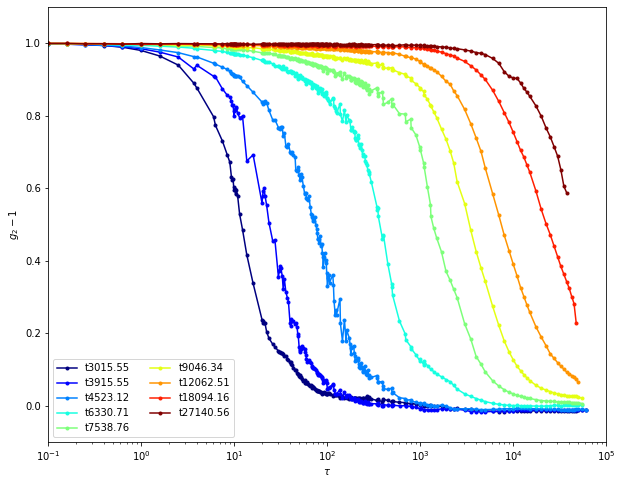

In [24]:
baselines = [0, 0, 0, 0, 0.03, 0.06, 0.07, 0.09, 0, 0]
idx = 7
corr_logy = False
save_file = None if corr_logy else os.path.join(froot, 'g2m1_ROI' + str(idx).zfill(3) + '_corr.dat')
fig, ax= PlotCorrFuncs(g2m1s[idx], lags, times, t_sel=[10, 13, 15, 21, 25, 30, 40, 60, 90], cmap=mpl.cm.jet, logG2M1=corr_logy, logy=corr_logy, 
                       baseline=baselines[idx], start='first', plot_fmt='.-', legend=False, min_corrval=None, save_file=save_file)
if corr_logy:
    ax.set_ylim([1e-4, 3])
else:
    ax.set_ylim([-0.1, 1.1])
    #ax.hlines([0], xmin=0.1, xmax=1e5)
ax.set_xlim([0.1, 1e5])
ax.legend(ncol=2)